Our task is simple: unify and standardize ISO data sets into 1 dataframe
Here are the things we need to make sure we are doing:
- converting any timestamps or time associated data columns to datetime
- making sure that we are labeling where each sub data set comes from (e.g. ERCOT, SPP, etc.)
- making sure that we are able to apply transformations to datasets in 2 phases
    - phase 1: transformations on each ISO before merging to main df 
    - phase 2: transformations on the main df

In [1]:
import pandas as pd
import geopandas as gpd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import date, datetime, timedelta
import transform_lmp_data as tld

In [2]:
# allows us to define a date and from that assemble correct path refs
## today = date.today()  <-- only use this if you just pulled data today

# defining our date
today = "2025-05-17"  # should always be in the YYYY-MM-DD format

year_str = str(today)[:4]
month_str = str(today)[5:7]
day_str = str(today)[-2:]


print(today)
print(f'year string: {year_str}')
print(f'month string: {month_str}')
print(f'day string: {day_str}')

2025-05-17
year string: 2025
month string: 05
day string: 17


In [3]:
# loading in data that we have pulled
ercot_data = pl.read_csv(f'datasets/ercot_lmp_data/lmp_node_zone_hub_csv/{today}_lmp_node_zone_hub.csv')
spp_data = pl.read_csv(f'datasets/spp_lmp_data/LMP_By_SETTLEMENT_LOC/LMP_By_SETTLEMENT_LOC_{year_str}{month_str}{day_str}.csv')
nyiso_data = pl.read_csv(f'datasets/nyiso_lmp_data/realtime_zone/{year_str}{month_str}{day_str}.csv')
isone_data = pl.read_csv(f'datasets/isone_lmp_data/fiveminutelmp_csv/fiveminutelmp_{year_str}{month_str}{day_str}.csv')
caiso_data = pl.read_csv(f'datasets/caiso_lmp_data/lmp_csv_merged/{year_str}{month_str}{day_str}_lmp.csv')
pjm_data = pl.read_csv(f'datasets/pjm_lmp_data/rt_unverified_fivemin_lmps_csv/{month_str}-{day_str}-{year_str}.csv')
miso_data = pl.read_csv(f'datasets/miso_lmp_data/lmp_csv/{year_str}-{month_str}-{day_str}_lmp.csv')

In [4]:
ercot_data.describe()

statistic,SCEDTimestamp,repeatHourFlag,settlementPoint,LMP
str,str,f64,str,f64
"""count""","""500000""",500000.0,"""500000""",500000.0
"""null_count""","""0""",0.0,"""0""",0.0
"""mean""",null,0.0,null,30.051929
"""std""",null,null,null,23.372946
"""min""","""2025-05-17T04:30:13""",0.0,"""7RNCHSLR_ALL""",-540.49
"""25%""",null,null,null,21.74
"""50%""",null,null,null,25.53
"""75%""",null,null,null,33.44
"""max""","""2025-05-18T20:10:11""",0.0,"""ZIER_SLR_ALL""",1186.32


In [5]:
# transforming our data sets before the main merge so that we can view it
ercot_df = tld.transform_ercot_data(ercot_df=ercot_data)
spp_df = tld.transform_spp_data(spp_df=spp_data)
nyiso_df = tld.transform_nyiso_data(nyiso_df=nyiso_data)
isone_df=tld.transform_isone_data(isone_df=isone_data)
caiso_df = tld.transform_caiso_data(caiso_df=caiso_data)
pjm_df = tld.transform_pjm_data(pjm_df=pjm_data)
miso_df = tld.transform_miso_data(miso_df=miso_data)

ercot_df.describe()
#spp_df.describe()
#nyiso_df.describe()
#isone_df.describe()
#caiso_df.describe()
#pjm_df.describe()
#miso_df.describe()

statistic,timestamp,repeatHourFlag,node_id,5min_lmp,iso_id,hour,minute
str,str,f64,str,f64,str,f64,f64
"""count""","""500000""",500000.0,"""500000""",500000.0,"""500000""",500000.0,500000.0
"""null_count""","""0""",0.0,"""0""",0.0,"""0""",0.0,0.0
"""mean""","""2025-05-18 00:14:58.818480""",0.0,null,30.051929,null,11.616782,27.147468
"""std""",null,null,null,23.372946,null,6.017352,17.284605
"""min""","""2025-05-17 04:30:00""",0.0,"""7RNCHSLR_ALL""",-540.49,"""ERCOT""",0.0,0.0
"""25%""","""2025-05-17 14:15:00""",null,null,21.74,null,7.0,10.0
"""50%""","""2025-05-18 00:15:00""",null,null,25.53,null,12.0,25.0
"""75%""","""2025-05-18 10:20:00""",null,null,33.44,null,16.0,40.0
"""max""","""2025-05-18 20:10:00""",0.0,"""ZIER_SLR_ALL""",1186.32,"""ERCOT""",23.0,55.0


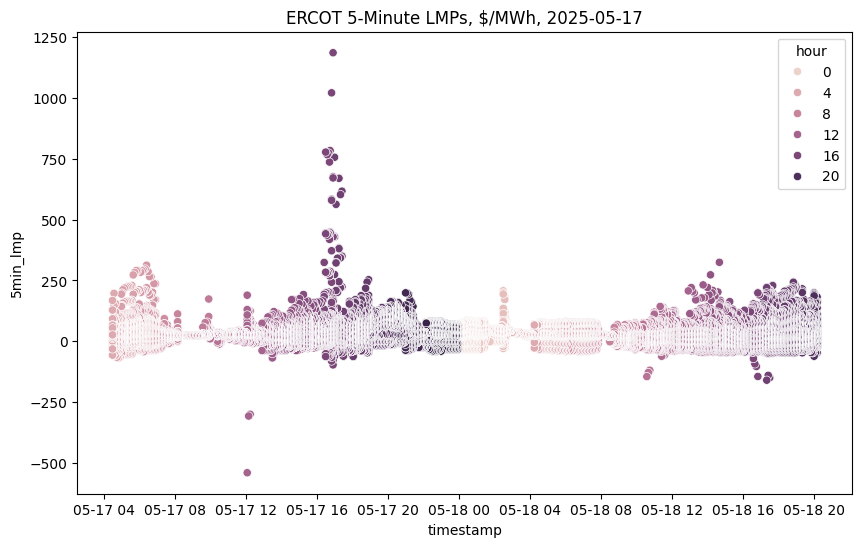

In [6]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=ercot_df, x='timestamp', y='5min_lmp', hue='hour')
plt.title(f'ERCOT 5-Minute LMPs, $/MWh, {today}')
plt.show()

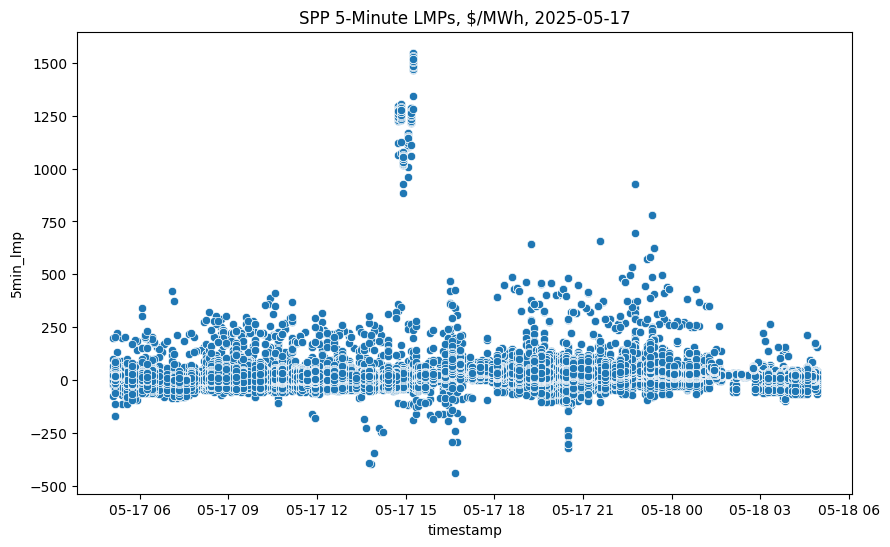

In [7]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=spp_df, x='timestamp', y='5min_lmp')
plt.title(f'SPP 5-Minute LMPs, $/MWh, {today}')
plt.show()

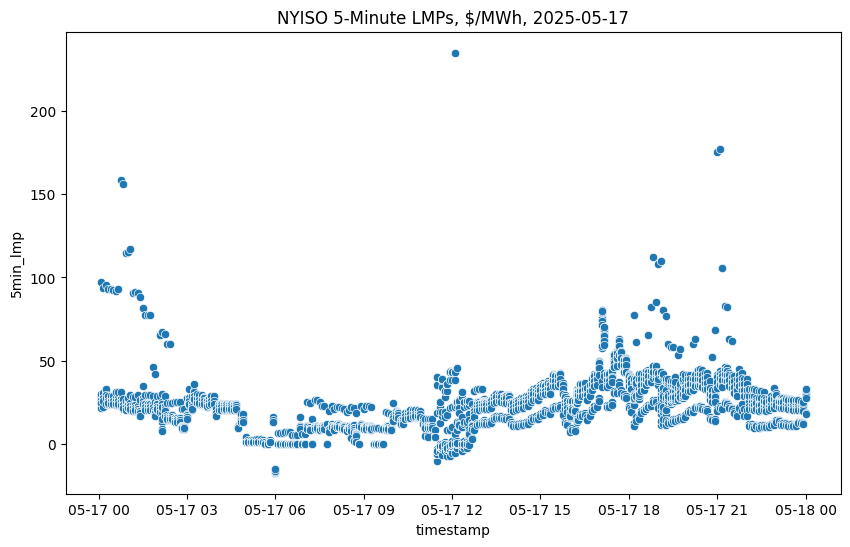

In [8]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=nyiso_df, x='timestamp', y='5min_lmp')
plt.title(f'NYISO 5-Minute LMPs, $/MWh, {today}')
plt.show()

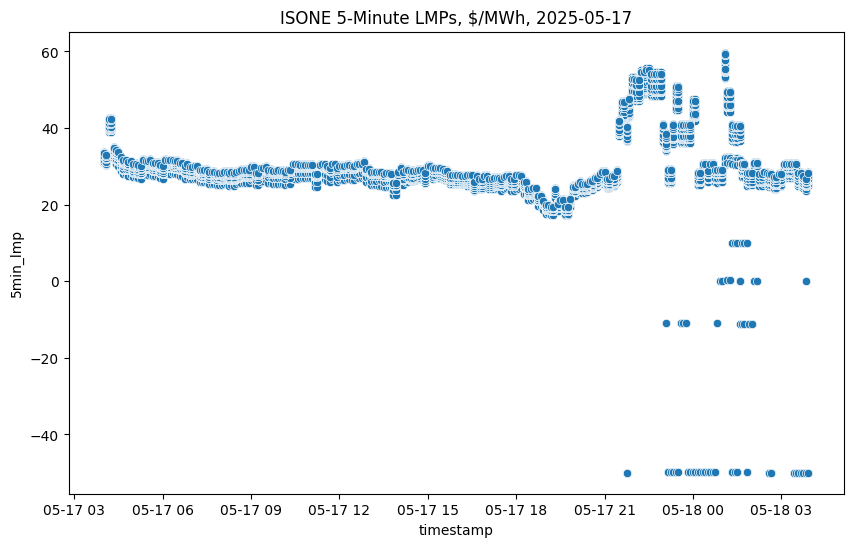

In [9]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=isone_df, x='timestamp', y='5min_lmp')
plt.title(f'ISONE 5-Minute LMPs, $/MWh, {today}')
plt.show()

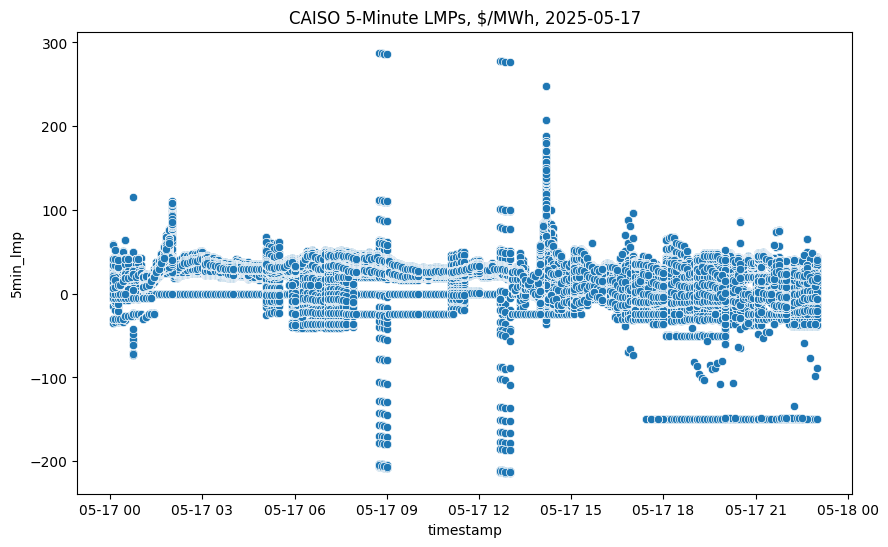

In [10]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=caiso_df, x='timestamp', y='5min_lmp')
plt.title(f'CAISO 5-Minute LMPs, $/MWh, {today}')
plt.show()

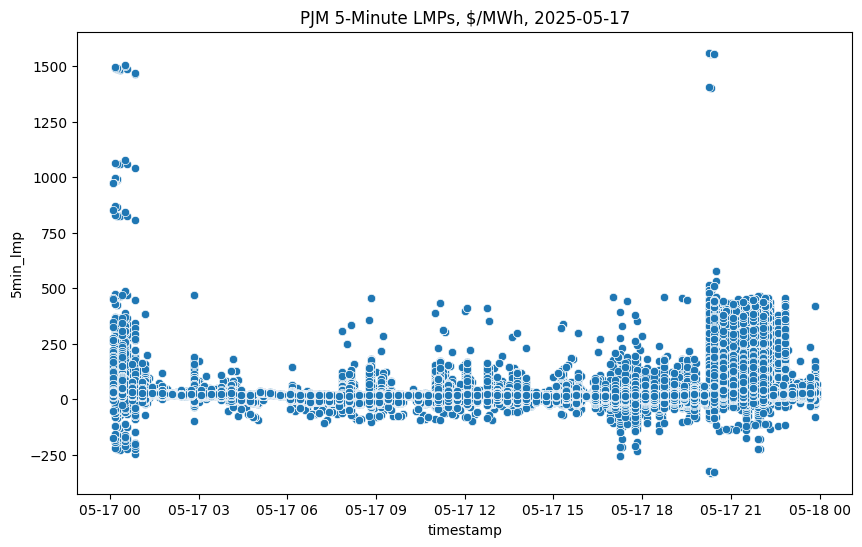

In [11]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=pjm_df, x='timestamp', y='5min_lmp')
plt.title(f'PJM 5-Minute LMPs, $/MWh, {today}')
plt.show()

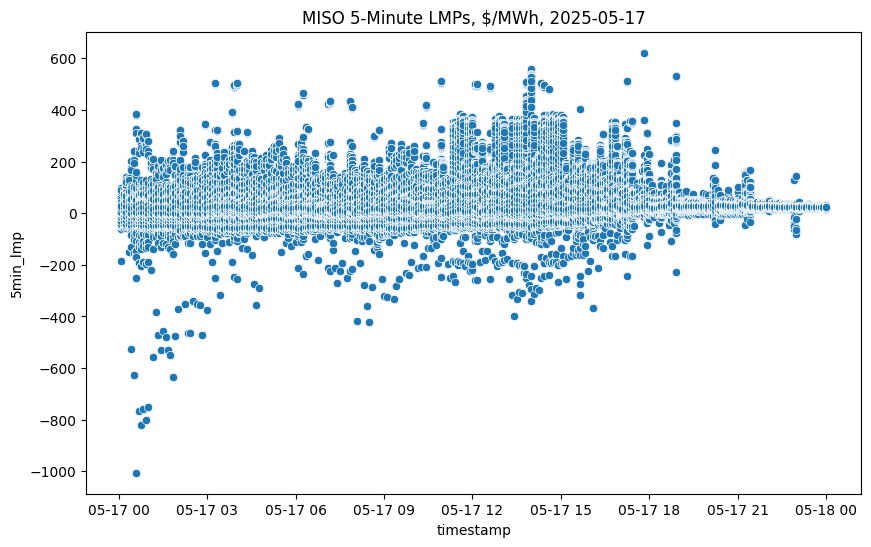

In [12]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=miso_df, x='timestamp', y='5min_lmp')
plt.title(f'MISO 5-Minute LMPs, $/MWh, {today}')
plt.show()

UNIFYING ISO DATA INTO 1 YAY! 10 MILLION DATA POINTS PER DAY :P

In [13]:
def create_std_timestamp(dataframes: list, cols_keep: list):
    '''
    Given a dataframe, convert timestamp to formmatted time stamp

    cols to keep default:
    ['node_id', 'timestamp', '5min_lmp', "iso_id"]
    '''
    df_filtered = [dataset.select(cols_keep) for dataset in dataframes]

    # here is where we will be adding our new dfs
    new_dfs = []

    # iterate through each df, and create a 'formatted_timestap' column that only includes Hour and Minute
    for df in df_filtered:
        temp_df = df.with_columns(
            pl.col('timestamp').dt.strftime("%m-%d-%Y %H:%M").alias('fmt_timestamp')
            )
        
        temp_df = temp_df.with_columns(
            pl.col("fmt_timestamp").str.strptime(pl.Datetime, format="%m-%d-%Y %H:%M")
        )

        new_dfs.append(temp_df)

    # removing timezone from columns with UTC timezone def
    new_dfs = [df.with_columns(
        pl.col("timestamp").dt.replace_time_zone(None), 
        pl.col('fmt_timestamp').dt.replace_time_zone(None)
    ) for df in new_dfs]

    combined_dfs = pl.concat(new_dfs, how="vertical")
    
    # converting into pandas df so it works with seaborn
    combined_pandas_df = combined_dfs.to_pandas()

    return combined_pandas_df

In [20]:
# create list of datasets
datasets = [caiso_df, ercot_df, isone_df, miso_df, nyiso_df,
            pjm_df, spp_df]     

# create a standardized timestamp on all datasets
datasets_fmt = create_std_timestamp(dataframes=datasets, 
                                    cols_keep=['node_id', 'timestamp', '5min_lmp', "iso_id", "hour", "minute"])

datasets_fmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10328848 entries, 0 to 10328847
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   node_id        object        
 1   timestamp      datetime64[us]
 2   5min_lmp       float64       
 3   iso_id         object        
 4   hour           int8          
 5   minute         int8          
 6   fmt_timestamp  datetime64[us]
dtypes: datetime64[us](2), float64(1), int8(2), object(2)
memory usage: 413.7+ MB


In [15]:
# only run this if you want to output final dataset
# datasets_fmt.to_csv(f'final_data/master_lmp_data_{today}.csv', index=False)

We have successfully pulled data for a given day across the united states, yay!
Now, let's create the following visuals
1. facet grid that shows 5 minute lmp data by ISO
2. facet grid that shows 5 minute lmp data by Hour and (hue) ISO
3. scatter plot that shows 5 minute lmp data by ISO (hue=ISO)

In [33]:
def lmp_iso_fgrid(dataset: object, fgrid_type = "standard"):
    '''
    Given a master dataset containing all LMP data by 7 ISOs, return a facet grid by ISO

    fgrid_type = standard (by iso), hour_iso (by hour with iso hue)
    '''

    if fgrid_type == "standard":
        plt.figure(figsize=[24,10])

        # creating facet grid with multiple plots based on iso_id
        g = sns.FacetGrid(data=dataset,  col='iso_id', col_wrap=4)

        # mapping scatter plot to each of the grid in the facet grid
        g.map(sns.scatterplot, 'fmt_timestamp', '5min_lmp', s=10)

        # rotating x axis labels by 90 degrees
        for ax in g.axes.flat:
            ax.tick_params(axis='x', rotation=90)

        g.set_axis_labels('', 'Locational Marginal Price (LMP, $/MWh)')
        g.fig.suptitle('USA Locational Marginal Pricing ($/MWh)', fontsize=12, y=1.03)

        plt.show()


    elif fgrid_type == "hour_iso":

        plt.figure(figsize=[24,10])

        # creating facet grid with multiple plots based on iso_id
        g = sns.FacetGrid(data=dataset,  col='hour', col_wrap=6, hue='iso_id')

        # mapping scatter plot to each of the grid in the facet grid
        g.map(sns.scatterplot, 'minute', '5min_lmp', s=10)

        g.add_legend()

        # rotating x axis labels by 90 degrees
        for ax in g.axes.flat:
            ax.tick_params(axis='x', rotation=90)

        g.set_axis_labels('', 'Locational Marginal Price (LMP, $/MWh)')
        g.fig.suptitle('USA Locational Marginal Pricing ($/MWh)', fontsize=12, y=1.03)

        plt.show()


    else: 
        print('please select one of the 2 presets!')
    

In [22]:
# filtered data for only 1 days worth of data because ERCOT pulled more than expected... idk why??
filtered_df = datasets_fmt[datasets_fmt['fmt_timestamp'].dt.date == pd.to_datetime(today).date()]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9984260 entries, 0 to 10327582
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   node_id        object        
 1   timestamp      datetime64[us]
 2   5min_lmp       float64       
 3   iso_id         object        
 4   hour           int8          
 5   minute         int8          
 6   fmt_timestamp  datetime64[us]
dtypes: datetime64[us](2), float64(1), int8(2), object(2)
memory usage: 476.1+ MB


<Figure size 2400x1000 with 0 Axes>

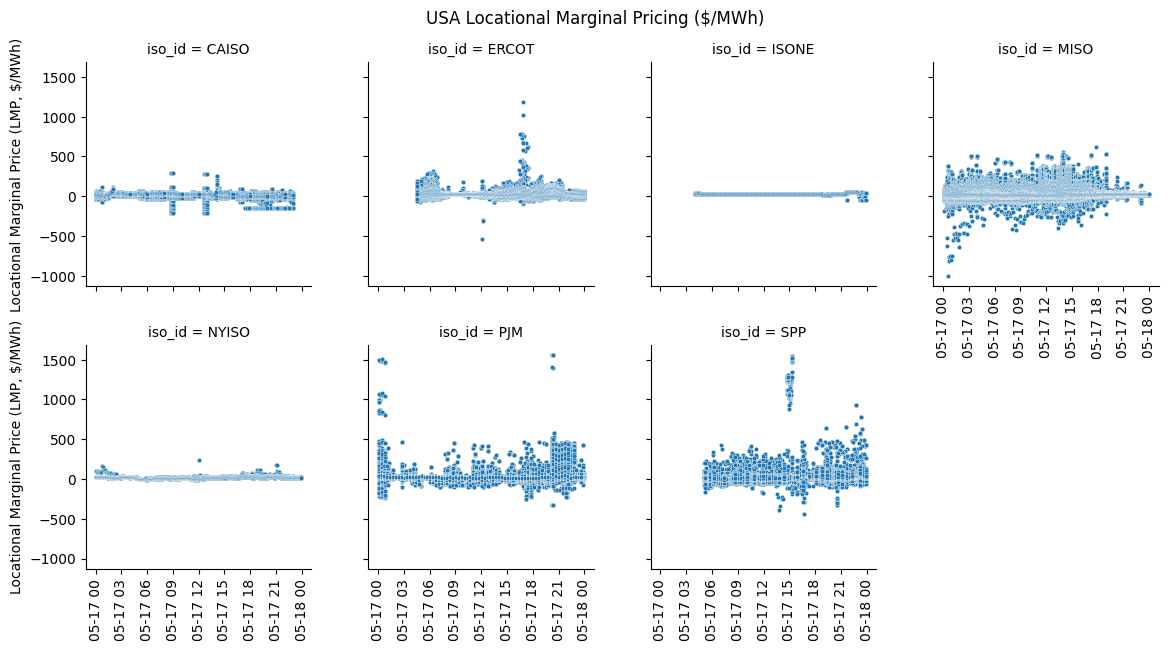

In [18]:
lmp_iso_fgrid(dataset=filtered_df, fgrid_type='standard')

<Figure size 2400x1000 with 0 Axes>

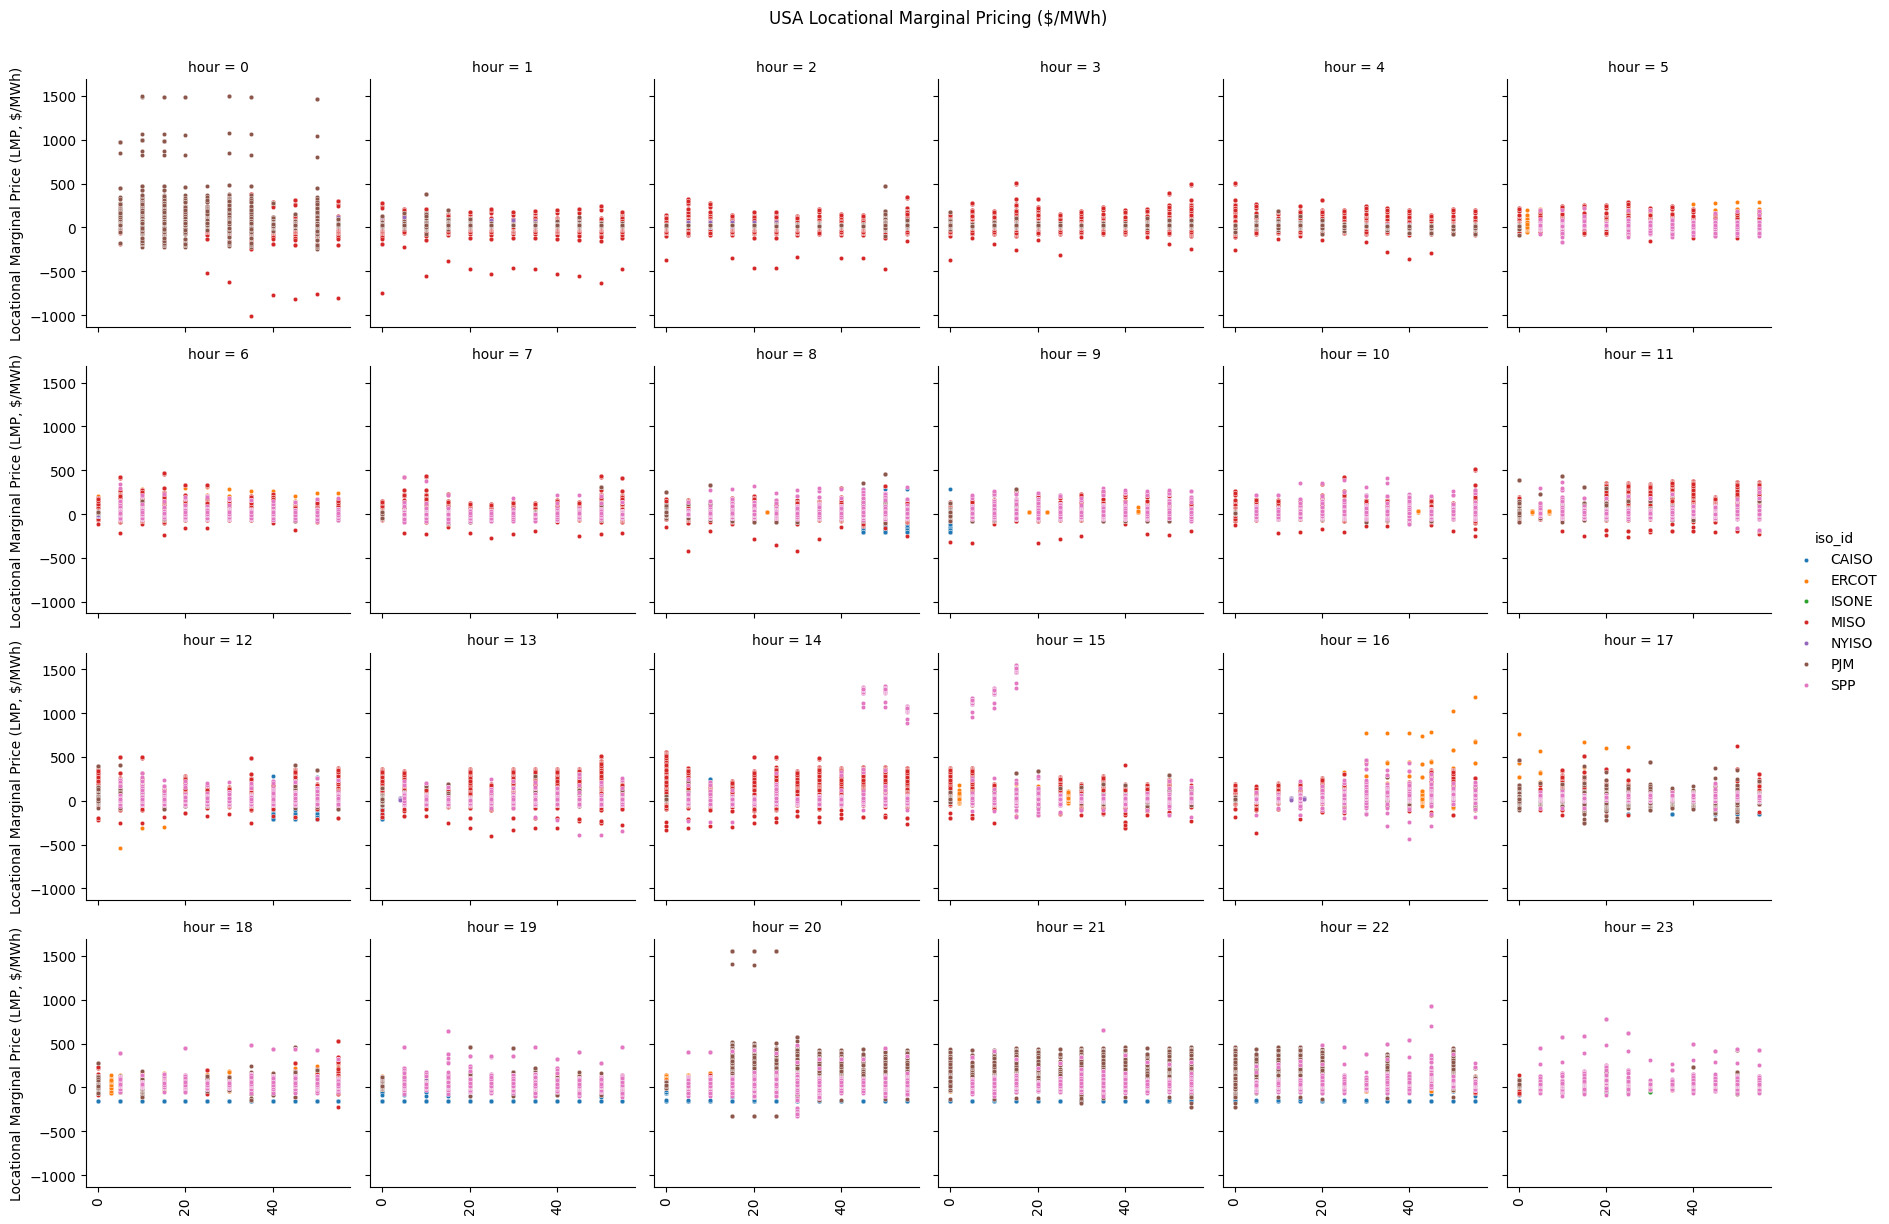

In [34]:
lmp_iso_fgrid(dataset=filtered_df, fgrid_type='hour_iso')

/Users/angelsalazar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


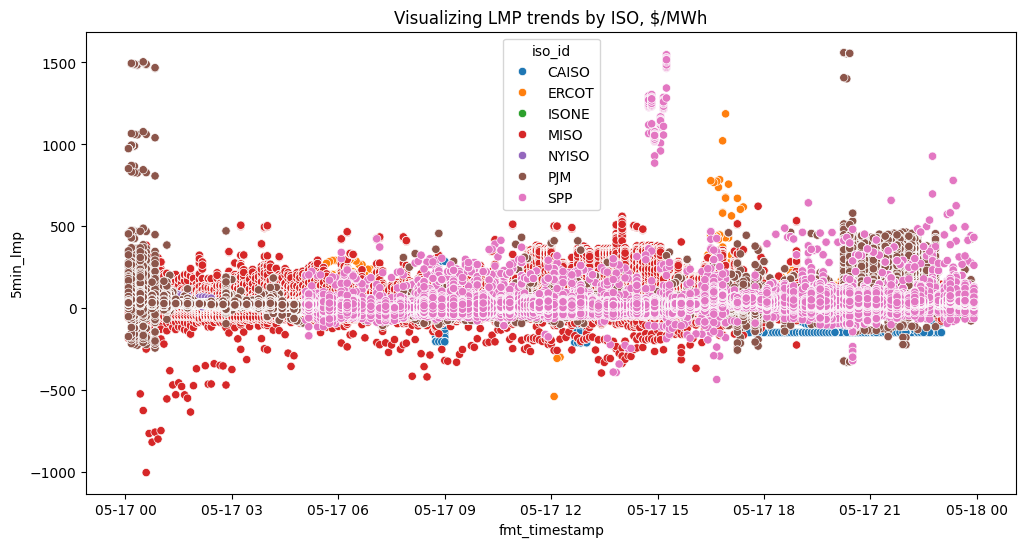

In [36]:
# now let's just quickly view scatter plot throughout the day and hue by iso_id
plt.figure(figsize=[12,6])

sns.scatterplot(data=filtered_df, x='fmt_timestamp', y='5min_lmp', hue='iso_id')

plt.title("Visualizing LMP trends by ISO, $/MWh")
plt.show()

In [54]:
def lmp_plot_distribution(dataset: object, vis_type = 'standard'):
    '''
    Purpose is to generate visuals associated with understanding distribution of data
    Options: standard (kde plot by iso_id), hour_iso (kde plot by hour and iso hue)
    '''
    if vis_type == "standard":
        # lets plot distribution of pricing
        plt.figure(figsize=[12,6])

        bins=range(-50, 170, 2) # low, high and seperate by N values

        g = sns.FacetGrid(data=filtered_df, col='iso_id', col_wrap=4)
        g.map(sns.kdeplot, '5min_lmp', clip=(-25, 100))  # clipping data range from -250 to 250 $/mwh
        g.add_legend()

        for ax in g.axes.flat:
            ax.tick_params(axis='x', rotation=90)

        g.set_axis_labels('Locational Marginal Pricing, $/MWh', 'Density')
        g.fig.suptitle('USA Locational Marginal Pricing ($/MWh)', fontsize=12, y=1.03)

        plt.grid(False)
        plt.figure()

    elif vis_type == "hour_iso":
        # lets plot distribution of pricing
        plt.figure(figsize=[12,6])

        bins=range(-50, 170, 2) # low, high and seperate by N values

        g = sns.FacetGrid(data=filtered_df, col='hour', col_wrap=6, hue='iso_id')
        g.map(sns.kdeplot, '5min_lmp', clip=(-25, 100))  # clipping data range from -250 to 250 $/mwh
        g.add_legend()

        for ax in g.axes.flat:
            ax.tick_params(axis='x', rotation=90)

        g.set_axis_labels('Locational Marginal Pricing, $/MWh', 'Density')
        g.fig.suptitle('USA Locational Marginal Pricing ($/MWh)', fontsize=12, y=1.03)

        plt.grid(False)
        plt.figure()

    else: 
        print('please choose a valid kde plot type!')
        

In [ ]:
lmp_plot_distribution(dataset=filtered_df, vis_type='standard')
lmp_plot_distribution(dataset=filtered_df, vis_type='hour_iso')

<Figure size 640x480 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

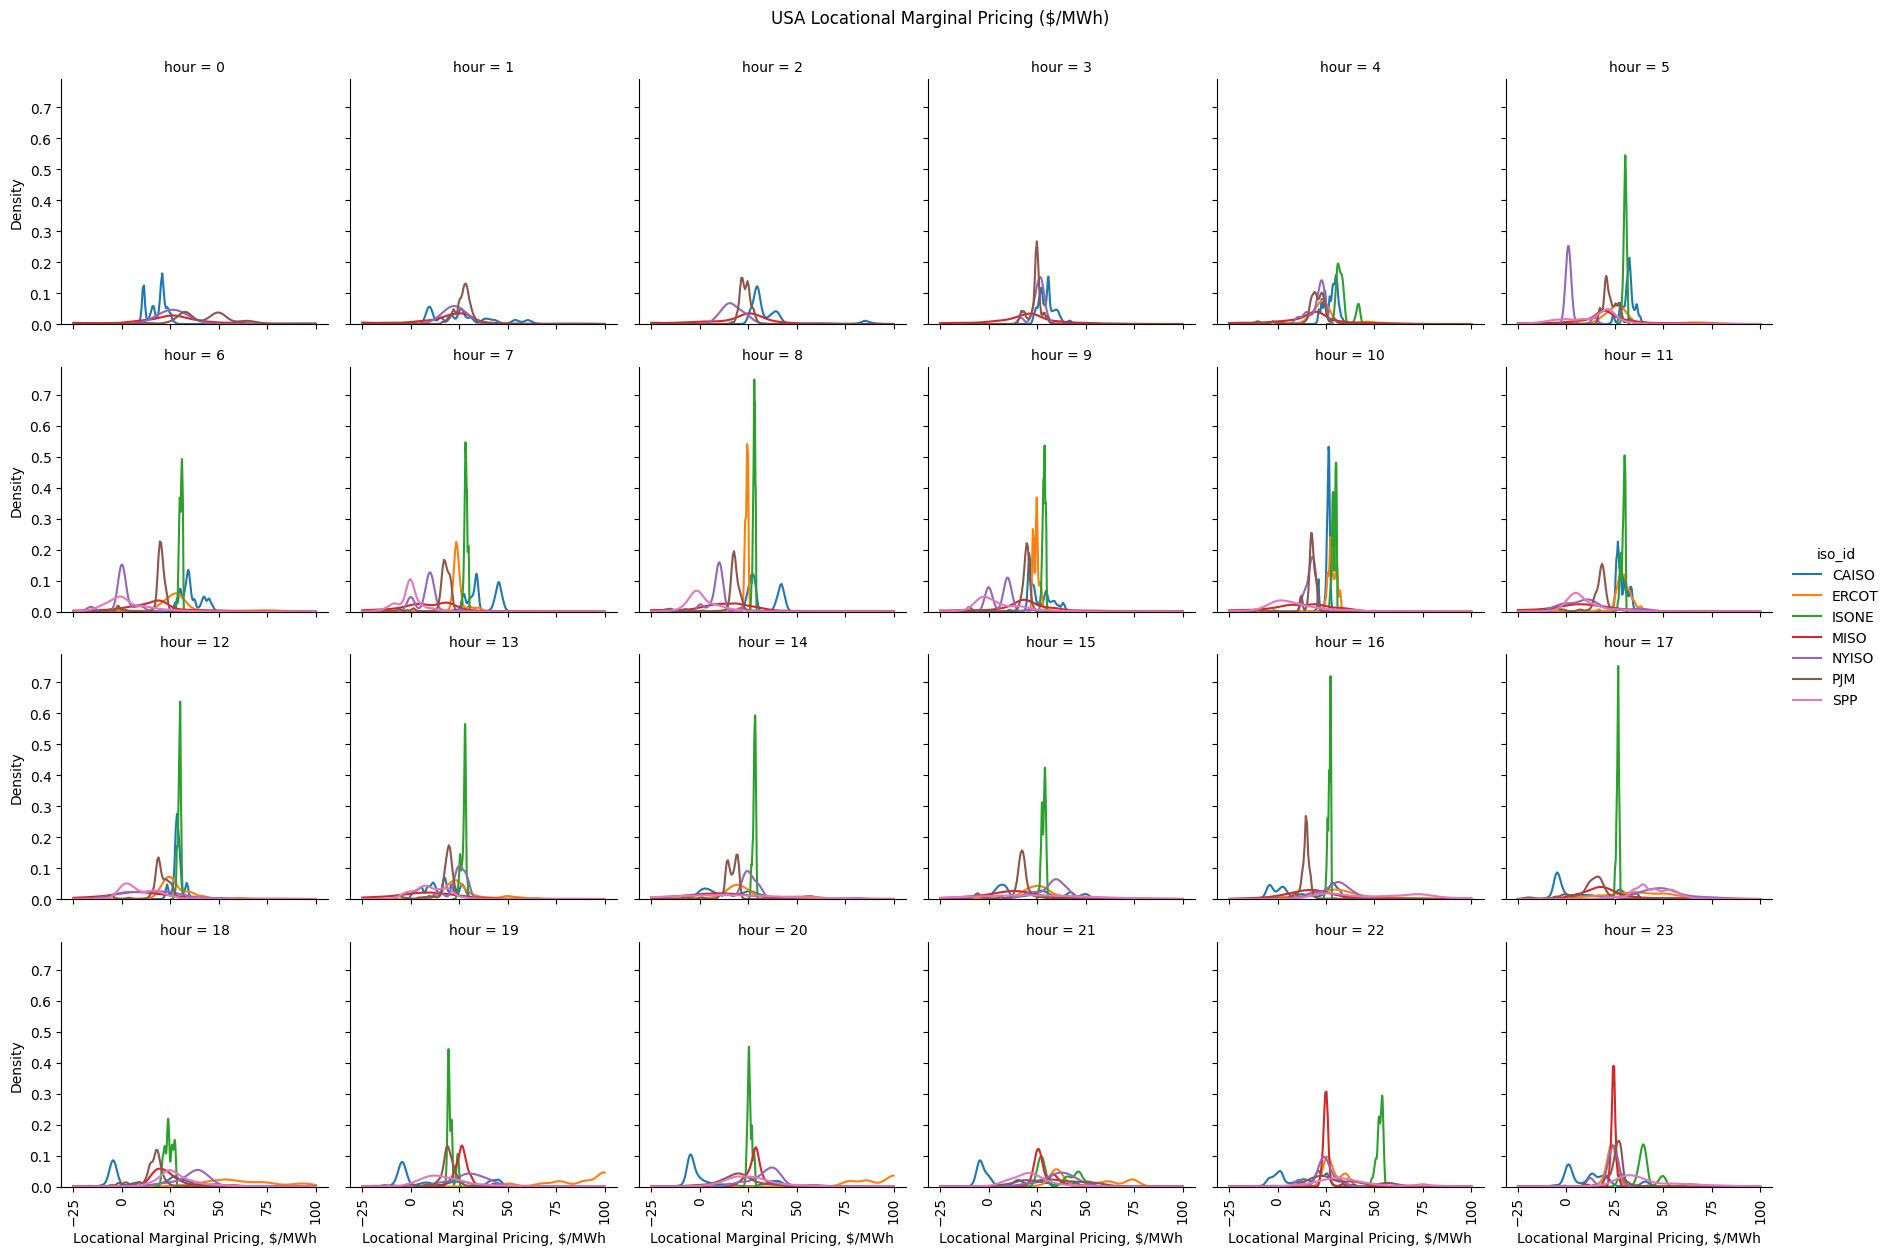

<Figure size 640x480 with 0 Axes>

In [ ]:
# lets plot distribution of pricing
plt.figure(figsize=[12,6])

bins=range(-50, 170, 2) # low, high and seperate by N values

g = sns.FacetGrid(data=filtered_df, col='hour', col_wrap=6, hue='iso_id')
g.map(sns.kdeplot, '5min_lmp', clip=(-25, 100))  # clipping data range from -250 to 250 $/mwh
g.add_legend()

for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)

g.set_axis_labels('Locational Marginal Pricing, $/MWh', 'Density')

plt.grid(False)
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

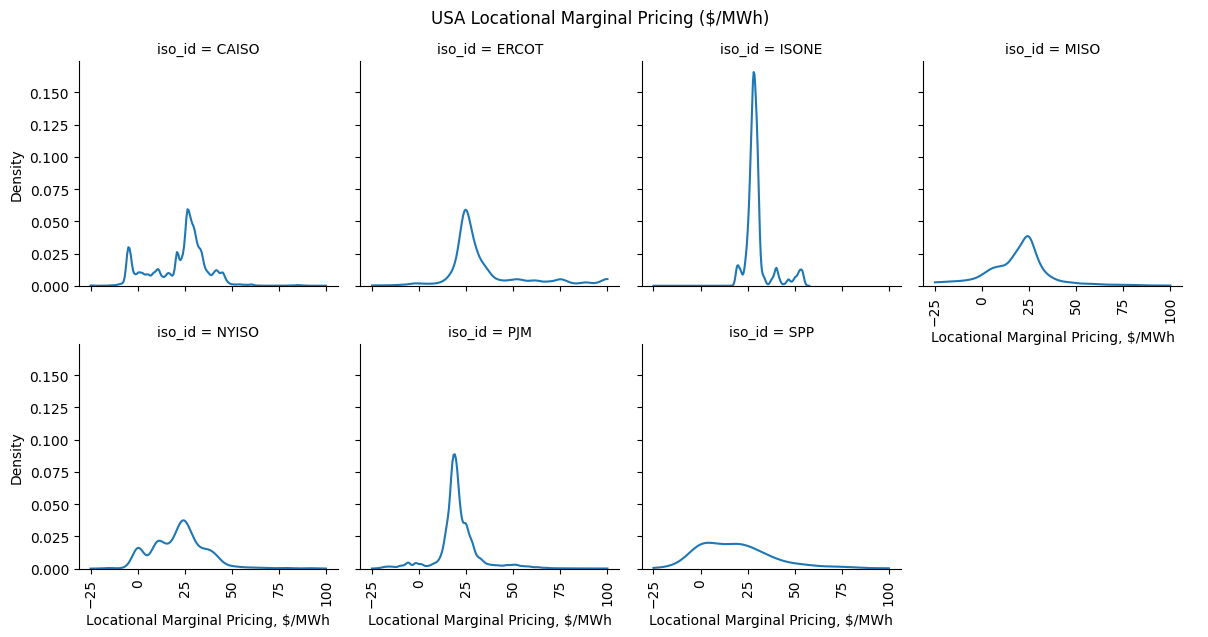

<Figure size 640x480 with 0 Axes>

In [50]:
# lets plot distribution of pricing
plt.figure(figsize=[12,6])

bins=range(-50, 170, 2) # low, high and seperate by N values

g = sns.FacetGrid(data=filtered_df, col='iso_id', col_wrap=4)
g.map(sns.kdeplot, '5min_lmp', clip=(-25, 100))  # clipping data range from -250 to 250 $/mwh
g.add_legend()

for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)

g.set_axis_labels('Locational Marginal Pricing, $/MWh', 'Density')
g.fig.suptitle('USA Locational Marginal Pricing ($/MWh)', fontsize=12, y=1.03)

plt.grid(False)
plt.figure()